# Generate cutouts from Netflora results

Predictions from the Netflora model are provided as a list of bounding boxes in txt files. 
Netflora cut the images into tiles.

Per tile, the model provides the bounding boxes of the detected flowers. The bounding boxes are provided in the format of proportion coordinates in that tile.

In this notebook, we will generate the cutouts of the detected bounding boxes of several classes. The cutouts will be saved in per class folders.

In [2]:
from pathlib import Path
import pandas as pd 
from PIL import Image 
import numpy as np # Open the image file img = Image.open('example.jpg')
from matplotlib import pyplot as plt

In [3]:
dir_labels = Path('../../../data/Netflora/runs/detect/exp/labels/')
dir_tiles = Path('../../../data/Netflora/processing/output_tiles/')
dir_tiles.exists()

True

In [4]:
# def crop_image(img, right, lower, wp, hp):
def crop_image(img, x, y, w, h):
    """crop image using Netflora prediction coordinates
       (0,0) is the top left corner of the image

    Parameters
    ----------
    img : PIL.Image
        imput image tile
    x : horizontal coordinares, center of the prediction box proportion 0-1
    y : vertical coordinares, center of the prediction box proportion 0-1
    w : decimal width proportion 0-1
    h : decimal height proportion 0-1
    """

    width, height = img.size
    left = x - w / 2
    upper = y - h / 2
    right = x + w / 2
    lower = y + h / 2
    img = img.crop((left * width, upper * height, right * width, lower * height))
    return img

In [5]:
label_list = list(dir_labels.glob('*.txt'))
label_list.sort()
label_list

[PosixPath('../../../data/Netflora/runs/detect/exp/labels/tile_1.txt'),
 PosixPath('../../../data/Netflora/runs/detect/exp/labels/tile_10.txt'),
 PosixPath('../../../data/Netflora/runs/detect/exp/labels/tile_11.txt'),
 PosixPath('../../../data/Netflora/runs/detect/exp/labels/tile_12.txt'),
 PosixPath('../../../data/Netflora/runs/detect/exp/labels/tile_13.txt'),
 PosixPath('../../../data/Netflora/runs/detect/exp/labels/tile_14.txt'),
 PosixPath('../../../data/Netflora/runs/detect/exp/labels/tile_15.txt'),
 PosixPath('../../../data/Netflora/runs/detect/exp/labels/tile_16.txt'),
 PosixPath('../../../data/Netflora/runs/detect/exp/labels/tile_17.txt'),
 PosixPath('../../../data/Netflora/runs/detect/exp/labels/tile_18.txt'),
 PosixPath('../../../data/Netflora/runs/detect/exp/labels/tile_19.txt'),
 PosixPath('../../../data/Netflora/runs/detect/exp/labels/tile_2.txt'),
 PosixPath('../../../data/Netflora/runs/detect/exp/labels/tile_20.txt'),
 PosixPath('../../../data/Netflora/runs/detect/exp/la

In [40]:
label_of_interest = 6
thres_similarity = 0.08
img_cutouts = []
for f_labels in label_list:
    # print(f_labels)
    # Read a label file
    df_labels = pd.read_csv(f_labels, sep=' ', header=None, index_col=False, names=['class', 'x', 'y', 'w', 'h', 'score'])
    df_labels_interest = df_labels[(df_labels['class'] == label_of_interest) & (df_labels['score'] > thres_similarity)]
    if len(df_labels_interest) > 0:
        f_tile = dir_tiles / f_labels.name.replace('txt', 'jpg')
        # Read the image as numpy array
        img = Image.open(f_tile)
        for i in range(len(df_labels_interest)):
            img_cutouts.append(crop_image(img, *df_labels_interest.iloc[i][['x', 'y', 'w', 'h']]))

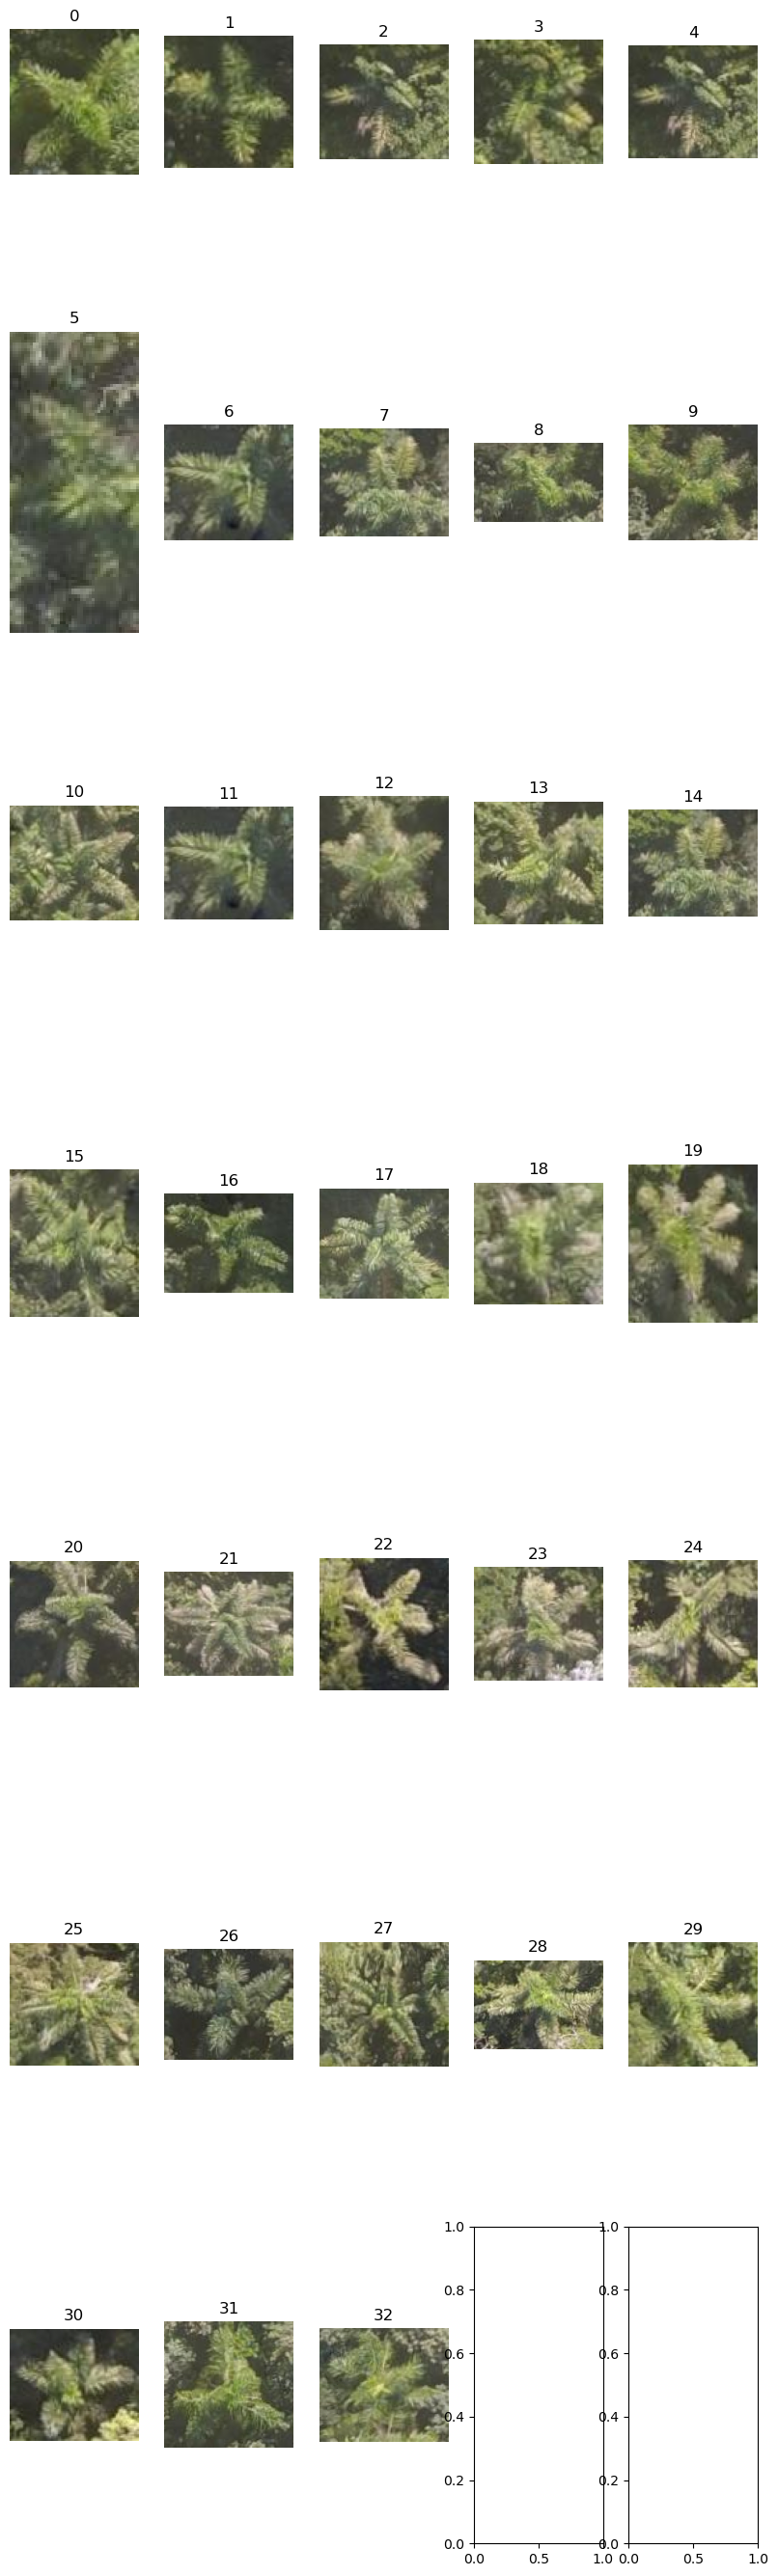

In [41]:
# visualize the cutouts
fig, axes = plt.subplots(len(img_cutouts) // 5+1, 5, figsize=(10, 5*(len(img_cutouts) // 5+1)))
for i, ax in enumerate(axes.flat):
    if i >= len(img_cutouts):
        break
    ax.imshow(img_cutouts[i])
    ax.title.set_text(f'{i}')
    ax.axis('off')

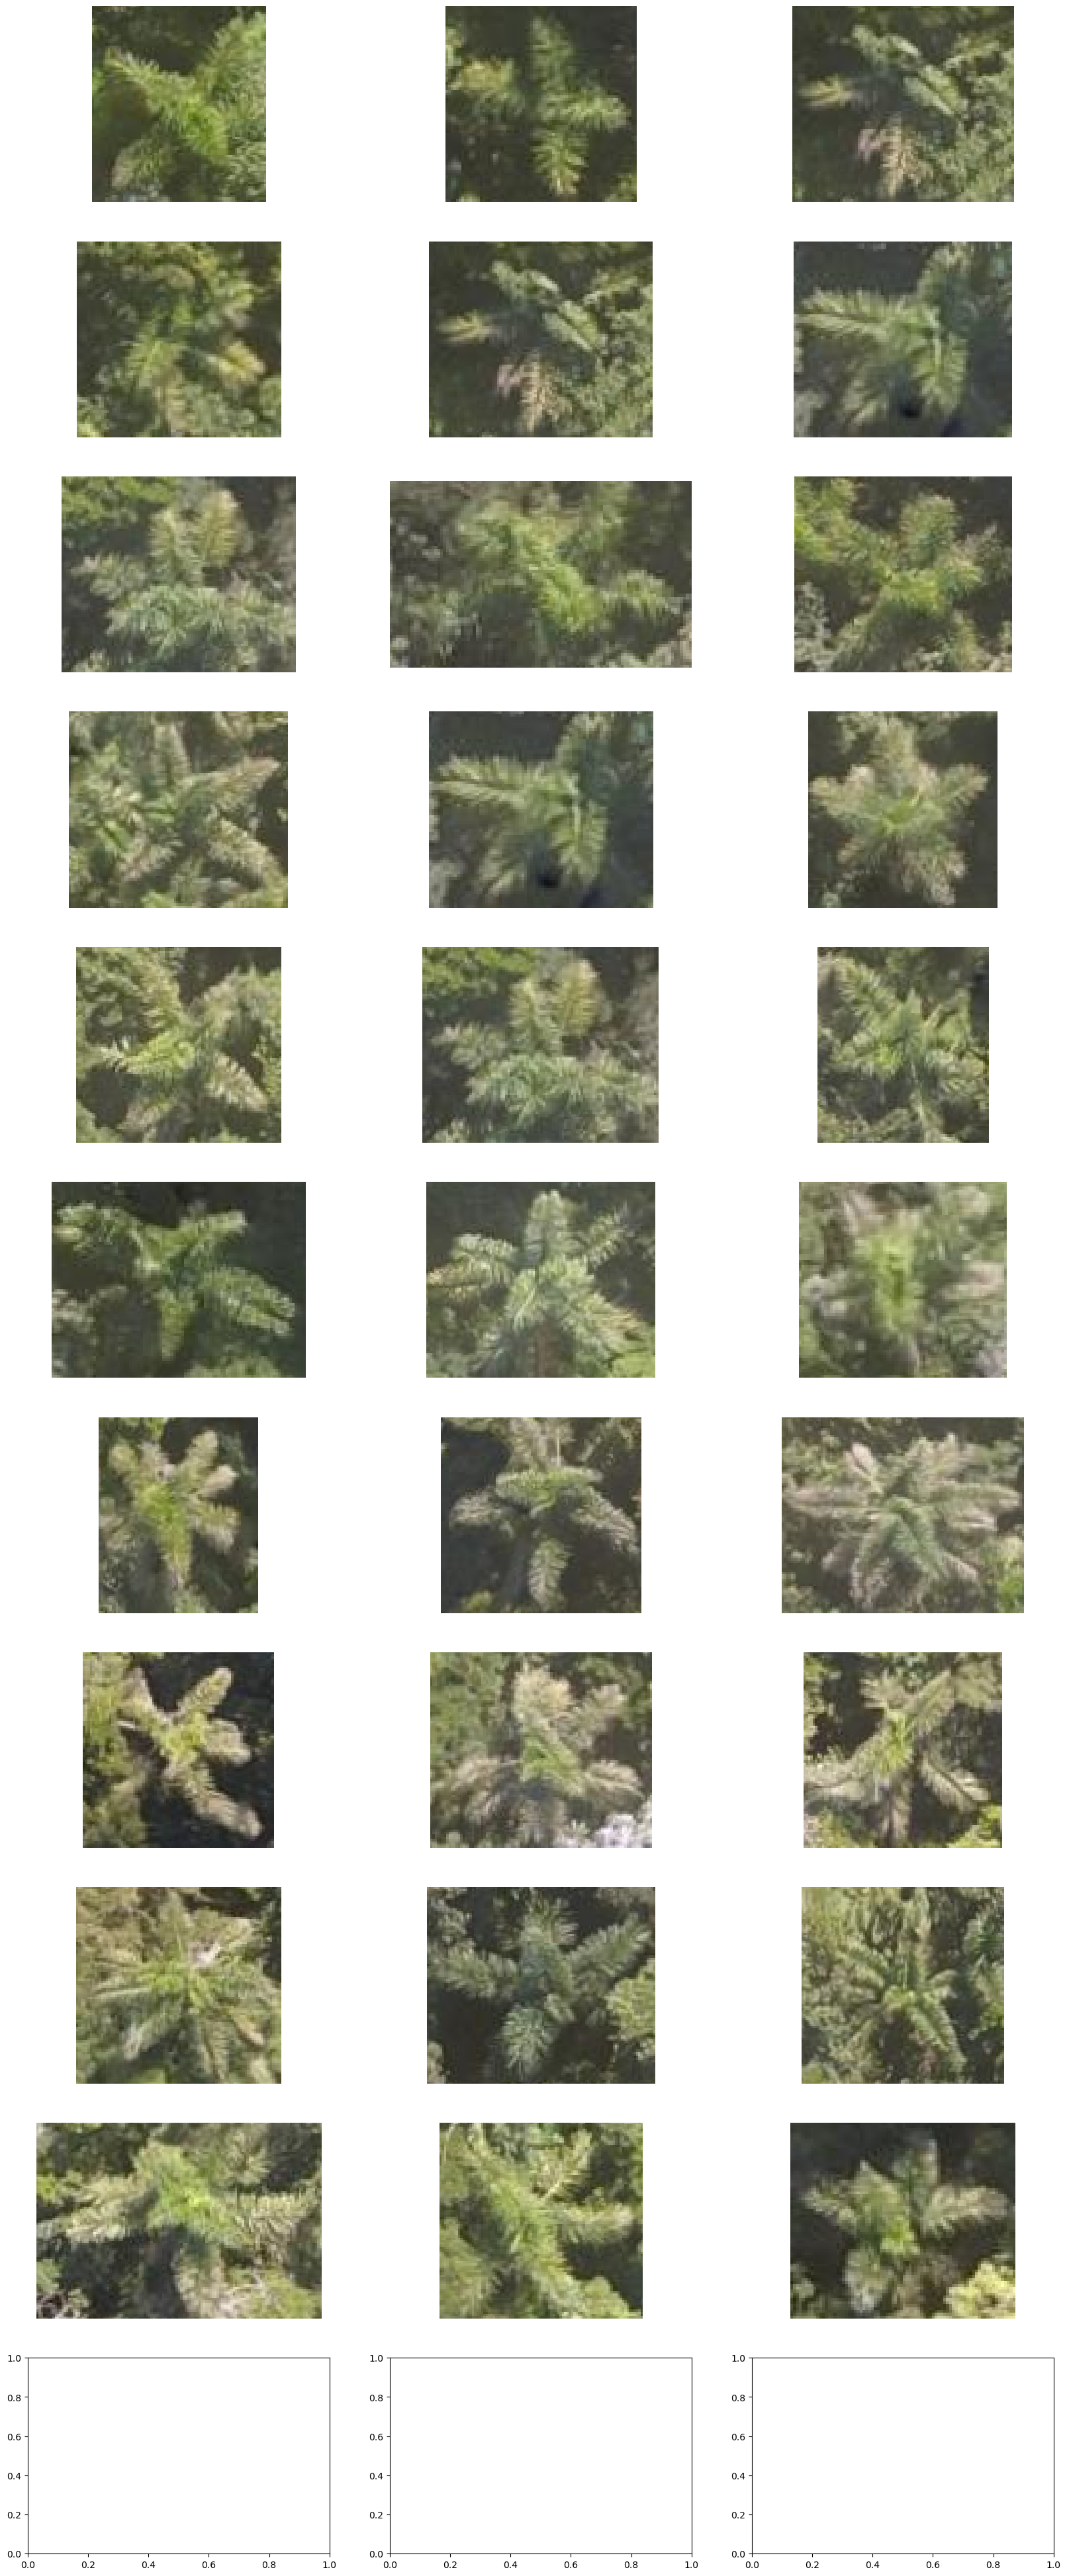

In [42]:
# Mannual selection of the cutouts, (starting from 0)
# index_exclude = [7,8] # label 0
# index_exclude = [7,8,10] # label 1
# index_exclude = [10,13,18,31,42,47,52,53,54,55,58,59,60,61] # label 2
index_exclude = [5,31,32] # label 6
# index = [1,2,3,4,6,8,9,19,21,24] # label 5

img_cutouts_selected = [img_cutouts[i] for i in range(len(img_cutouts)) if i not in index_exclude]
# img_cutouts_selected = [img_cutouts[i] for i in index]

fig, axes = plt.subplots(len(img_cutouts_selected) // 3+1, 3, figsize=(20, 50))
for i, ax in enumerate(axes.flat):
    if i >= len(img_cutouts_selected):
        break
    ax.imshow(img_cutouts_selected[i])
    ax.axis('off')

In [43]:
# Save the selected cutouts
dir_output = Path(f'./output_cutouts/label_{label_of_interest}/')
dir_output.mkdir(parents=True, exist_ok=True)
for i, img in enumerate(img_cutouts_selected):
    img.save(dir_output / f'cutout_{i}.jpg')